@nipdep
## Segmentation model architecture

In [4]:
import time
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, GlobalAveragePooling2D, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, Concatenate, AveragePooling2D, MaxPooling2D, GlobalMaxPool2D, Lambda, Reshape, Add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1
from tensorflow.keras import losses
from tensorflow.keras import metrics 
import matplotlib.pyplot as plt 
from tensorflow.python.autograph.pyct import transformer

In [5]:
print(tf.__version__)

2.5.0


In [6]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g


In [7]:
def define_encoder(latent_size, input_shape=(128,128,3)):
    init = RandomNormal(stddev=0.01)
    input_Layer = Input(shape=input_shape)

    e1 = define_encoder_block(input_Layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)

    latent_layer = Conv2D(latent_size, (4,4), strides=(2,2), padding='same', kernel_initializer=init, activation='relu')(e5)
    avg_Pool = GlobalAveragePooling2D()(latent_layer)
    RS_layer = tf.keras.layers.Reshape((1, 1, avg_Pool.shape[-1]))(avg_Pool)
    model = Model(inputs=input_Layer, outputs=RS_layer, name="Encoder-model")
    return model


In [8]:
class EncoderNet(tf.keras.Model):

    def __init__(self, base_model):
        super(EncoderNet, self).__init__()
        self._model = base_model

    @tf.function
    def call(self, inputs):
        prev_image, next_image = inputs
        with tf.name_scope("Prev") as scope:
            ft1 = self._model(prev_image)
            ft1 = tf.math.l2_normalize(ft1)
        
        with tf.name_scope("Next") as scope:
            ft2 = self._model(next_image)
            ft2 = tf.math.l2_normalize(ft2)

        return [ft1, ft2]

In [9]:
base_model = define_encoder(512, (128,128,3))
enc_model = EncoderNet(base_model)

In [10]:
base_model.summary()

Model: "Encoder-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)     

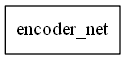

In [11]:
tf.keras.utils.plot_model(enc_model, show_shapes=True)

In [12]:
sample_input = [tf.zeros((32,128,128,3)), tf.zeros((32,128,128,3))]
# sample_input = tf.zeros((32,2,128,128,3))
out = enc_model(sample_input)

In [13]:
out[0].shape

TensorShape([32, 1, 1, 512])

In [14]:
def define_decoder_block(layer_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = ReLU()(g)
    return g

In [15]:
def define_decoder(encoder_model, image_shape=(128,128,3)):
    init = RandomNormal(stddev=0.01)
    pev_Image = Input(shape=image_shape, name='previous_image')
    nex_Image = Input(shape=image_shape, name='next_image')
    latent_Vec1, latent_Vec2 = encoder_model([pev_Image, nex_Image])

    Concat_Layer = Concatenate()([latent_Vec1, latent_Vec2])

    d1 = define_decoder_block(Concat_Layer, 512, dropout=False)
    d2 = define_decoder_block(d1, 512)
    d3 = define_decoder_block(d2, 512)
    d4 = define_decoder_block(d3, 256)
    d5 = define_decoder_block(d4, 128, dropout=False)
    d6 = define_decoder_block(d5, 64, dropout=False)

    g = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d6)
    out_image = Activation('tanh')(g)

    # assert out_image.shape[1:] == image_shape, LookupError("output image shape {0}, is not valid".format(image_shape))

    model = Model(inputs=[pev_Image, nex_Image], outputs=out_image, name='generator')
    return model    

In [16]:
model = define_decoder(enc_model, (128, 128, 3))

In [17]:
model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
previous_image (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
next_image (InputLayer)         [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_net (EncoderNet)        [(None, 1, 1, 512),  11151808    previous_image[0][0]             
                                                                 next_image[0][0]                 
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1, 1, 1024)   0           encoder_net[0][0]        

In [18]:
sample_input = [tf.zeros((32,128,128,3)), tf.zeros((32,128,128,3))]
out = model(sample_input)
out.shape

TensorShape([32, 128, 128, 1])

## Dataset & dataLoader

In [19]:
train_data = np.load('../../data/data/train_data.npz')
fimg_data = train_data['first_image']
simg_data = train_data['second_image']
mask_data = train_data['mask']

In [20]:
train_X1 = tf.data.Dataset.from_tensor_slices((fimg_data, simg_data))
# train_X2 = tf.data.Dataset.from_tensor_slices(simg_data)
mask_y = tf.data.Dataset.from_tensor_slices(np.expand_dims(mask_data, -1))
train_dt = tf.data.Dataset.zip((train_X1, mask_y))
train_dt.element_spec

((TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None),
  TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None)),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint16, name=None))

In [21]:
def normalize(imgs, mask):
    # one, zero = tf.ones_like(mask), tf.zeros_like(mask)
    (img1, img2) = imgs
    img1 = img1/255
    img2 = img2/255
    # mask = mask/tf.math.reduce_max(mask)
    # mask = tf.where(mask > 0.0, x=one, y=zero)
    return (tf.cast(img1, dtype=tf.float32),tf.cast(img2, dtype=tf.float32)), tf.cast(mask, dtype=tf.float32)

def rescale(imgs, mask, scale=(128,128)):
    img1, img2 = imgs
    img1 = tf.image.resize(img1, scale, preserve_aspect_ratio=True, antialias=True)
    img2 = tf.image.resize(img2, scale, preserve_aspect_ratio=True, antialias=True)
    mask = tf.image.resize(mask, scale, preserve_aspect_ratio=True, antialias=True)
    return (tf.cast(img1, dtype=tf.float32),tf.cast(img2, dtype=tf.float32)), tf.cast(mask, dtype=tf.float32)

def brightness(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_brightness(img1, 0.1)
        img2 = tf.image.adjust_brightness(img2, 0.1)
    return (img1, img2), mask

def gamma(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_gamma(img1, 0.1)
        img2 = tf.image.adjust_gamma(img2, 0.1) 
    return (img1, img2), mask

def hue(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_hue(img1, -0.1)
        img2 = tf.image.adjust_hue(img2, -0.1)
    return (img1, img2), mask

# def crop(img, mask):
#      img = tf.image.central_crop(img, 0.7)
#      img = tf.image.resize(img, (128,128))
#      mask = tf.image.central_crop(mask, 0.7)
#      mask = tf.image.resize(mask, (128,128))
#      mask = tf.cast(mask, tf.uint8)
#      return img, mask

def flip_hori(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_left_right(img1)
        img2 = tf.image.flip_left_right(img2)
        mask = tf.image.flip_left_right(mask)
    return (img1, img2), mask

def flip_vert(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_up_down(img1)
        img2 = tf.image.flip_up_down(img2)
        mask = tf.image.flip_up_down(mask)
    return (img1, img2), mask

def rotate(imgs, mask):
    img1, img2 = imgs
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.rot90(img1)
        img2 = tf.image.rot90(img2)
        mask = tf.image.rot90(mask)
    return (img1, img2), mask

def bundle(img1, img2, mask):
    return [img1, img2], mask
# %%
# perform augmentation on train data only
# train_dt = train_dt.map(normalize)
train_dt = train_dt.map(rescale)
train_dt = train_dt.map(normalize)
a = train_dt.map(brightness)
b = train_dt.map(gamma)
e = train_dt.map(flip_hori)
f = train_dt.map(flip_vert)
g = train_dt.map(rotate)

train_dt = train_dt.concatenate(a)
train_dt = train_dt.concatenate(b)
train_dt = train_dt.concatenate(e)
train_dt = train_dt.concatenate(f)
train_dt = train_dt.concatenate(g)
# train_dt = train_dt.map(bundle)

In [22]:
train_dt.element_spec

((TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

In [23]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())
sample_imgs[0][0][0].shape

(128, 128, 3)

input image shape :  (128, 128, 3) mask image shape :  (128, 128, 1)


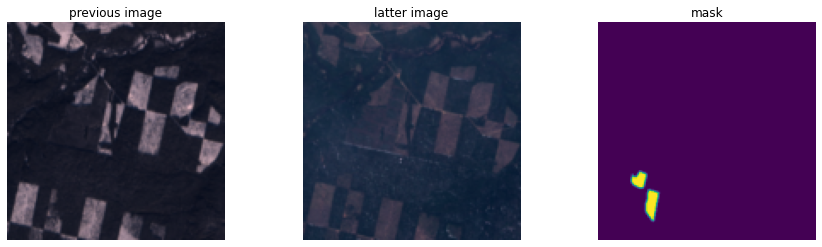

In [24]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0][0]
s_img = sample_imgs[0][1]
mask_img = sample_imgs[1]

plt.figure(figsize=(15,4))
print("input image shape : ", f_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("previous image")
plt.imshow(f_imgs)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("latter image")
plt.imshow(s_img)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("mask")
plt.imshow(mask_img)


In [25]:
BATCH = 32
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train_dt = train_dt.cache().shuffle(BUFFER).batch(BATCH).repeat()
train_dt = train_dt.prefetch(buffer_size=AT)

## Model Training

In [32]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [33]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 20s 736ms/step - loss: 0.0510 - root_mean_squared_error: 0.2346
Epoch 2/10
25/25 [==============================] - 19s 761ms/step - loss: 0.0471 - root_mean_squared_error: 0.2403
Epoch 3/10
25/25 [==============================] - 19s 766ms/step - loss: 0.0480 - root_mean_squared_error: 0.2318
Epoch 4/10
25/25 [==============================] - 19s 763ms/step - loss: 0.0516 - root_mean_squared_error: 0.2257
Epoch 5/10
25/25 [==============================] - 19s 762ms/step - loss: 0.0523 - root_mean_squared_error: 0.1946
Epoch 6/10
25/25 [==============================] - 19s 760ms/step - loss: 0.0471 - root_mean_squared_error: 0.1712
Epoch 7/10
25/25 [==============================] - 19s 769ms/step - loss: 0.0454 - root_mean_squared_error: 0.1834
Epoch 8/10
25/25 [==============================] - 19s 753ms/step - loss: 0.0463 - root_mean_squared_error: 0.1946
Epoch 9/10
25/25 [==============================] - 20s 779ms/step - los

In [34]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0][0]
s_img = sample_imgs[0][1]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

In [35]:
pred.shape

(32, 128, 128, 1)

input image shape :  (32, 128, 128, 3) mask image shape :  (32, 128, 128, 1)


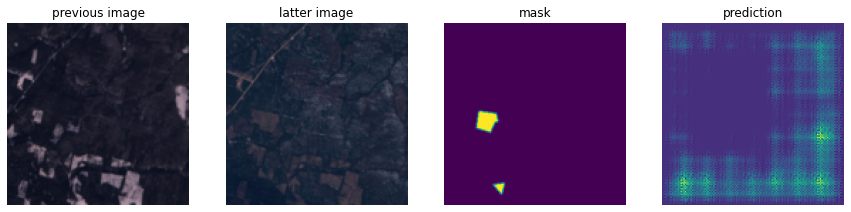

In [38]:

plt.figure(figsize=(15,4))
print("input image shape : ", f_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.title("previous image")
plt.imshow(f_imgs[10])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.title("latter image")
plt.imshow(s_img[10])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.title("mask")
plt.imshow(mask_img[10])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[10])

### using regression loss function

In [39]:
model.compile(loss='mse',
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [40]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 20s 719ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232
Epoch 2/10
25/25 [==============================] - 19s 744ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905
Epoch 3/10
25/25 [==============================] - 19s 768ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827
Epoch 4/10
25/25 [==============================] - 20s 788ms/step - loss: 0.0066 - root_mean_squared_error: 0.0811
Epoch 5/10
25/25 [==============================] - 20s 797ms/step - loss: 0.0069 - root_mean_squared_error: 0.0828
Epoch 6/10
25/25 [==============================] - 20s 786ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774
Epoch 7/10
25/25 [==============================] - 20s 784ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872
Epoch 8/10
25/25 [==============================] - 19s 778ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835
Epoch 9/10
25/25 [==============================] - 19s 779ms/step - los

In [42]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0][0]
s_img = sample_imgs[0][1]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (32, 128, 128, 3) mask image shape :  (32, 128, 128, 1)


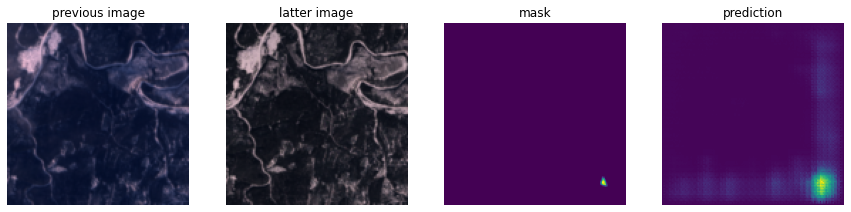

In [45]:
plt.figure(figsize=(15,4))
print("input image shape : ", f_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.title("previous image")
plt.imshow(f_imgs[2])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.title("latter image")
plt.imshow(s_img[2])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.title("mask")
plt.imshow(mask_img[2])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[2])

In [46]:
model.save_weights('../../data/models/defo_mask2.h5')